In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import scipy.sparse
sys.path.append('/home/groups/dpwall/briannac/sequence_based_biomarkers/src/nonparametric_pvalues')
from fast_stats import *
import pandas as pd
import seaborn as sns 
BIOMARKER_DIR = '/home/groups/dpwall/briannac/sequence_based_biomarkers/'

# FDR Curves

In [16]:
dfs = pd.DataFrame()
for dataset in ['obesity', 'autism']:
    sample_data = pd.read_table(BIOMARKER_DIR + 'data/%s/sample_metadata.tsv' % (dataset))
    for biomarker in ['otu95', 'otu97', 'otu99', 'micropheno4','micropheno6', 'micropheno8', 'sbb1', 'sbb2', 'sbb3']:
        print(biomarker)
        stats = abs(np.load('/home/groups/dpwall/briannac/sequence_based_biomarkers/results/rank_stats/rank_stat_%s_%s.npy' % (dataset, biomarker)))
        permuted_stats = []
        for iter_idx in range(1,10):
            permuted_stats = permuted_stats + list(
                abs(np.loadtxt('/home/groups/dpwall/briannac/sequence_based_biomarkers/intermediate_files/nonparametric_pvalues/%s_%s/permuted_rank_stat_%s_%s_%i.txt' % (
                    dataset, biomarker, dataset, biomarker, iter_idx))))
        bins = np.linspace(np.percentile(stats, 75),max(stats), 1000)
        data_counts = countGreaterThanEqual(bins, sorted(stats))
        permuted_counts = countGreaterThanEqual(bins, sorted(permuted_stats))
        FDR = [fp/ap for fp, ap in zip(permuted_counts[::-1]/len(permuted_stats), data_counts[::-1]/len(stats))]
        FDR = [min(FDR[i:]) for i in range(len(FDR))]
        df = pd.DataFrame([data_counts[::-1]/len(stats), FDR]).transpose()
        df['biomarker'] = biomarker
        df['dataset'] = dataset
        dfs = pd.concat([dfs, df])
dfs.columns = ['x', 'y', 'biomarker', 'dataset']
dfs.to_csv('/home/groups/dpwall/briannac/sequence_based_biomarkers/results/rank_stats/fdr_dataframe.tsv', sep='\t')

otu95
otu97
otu99
micropheno4
micropheno6
micropheno8
sbb1
sbb2
sbb3
otu95
otu97
otu99
micropheno4
micropheno6
micropheno8
sbb1
sbb2
sbb3


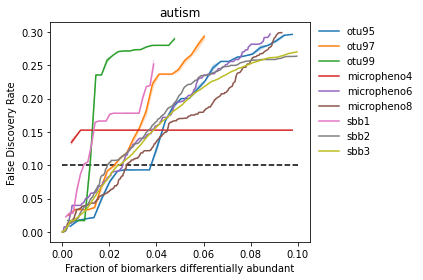

In [36]:
dfs = pd.read_csv('/home/groups/dpwall/briannac/sequence_based_biomarkers/results/rank_stats/fdr_dataframe.tsv', sep='\t')
sns.lineplot(data=dfs[(dfs.x<=.1)& (dfs.y<=.3)& (dfs.dataset=='autism')], x='x', y='y', hue='biomarker')
#plt.xlim(0,.1)
#plt.ylim(.01, .3)
plt.hlines(y=.1, xmin=0, xmax=.1, color='black', linestyles='dashed')
plt.xlabel('Fraction of biomarkers differentially abundant')
plt.ylabel('False Discovery Rate')
plt.title('autism')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/sequence_based_biomarkers/results/rank_stats/fdr_autism.svg',
            transparent=True,pad_inches = 0, bbox_inches='tight')
plt.show()

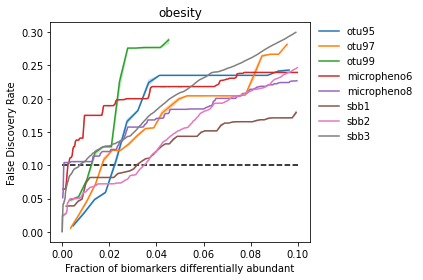

In [33]:
sns.lineplot(data=dfs[(dfs.x<=.1)& (dfs.y<=.3)& (dfs.dataset=='obesity')], x='x', y='y', hue='biomarker')
#plt.yscale('log')
#plt.xlim(0,.1)
#plt.ylim(.01, .3)
plt.hlines(y=.1, xmin=0, xmax=.1, color='black', linestyles='dashed')
#plt.xlim(0,1)
plt.xlabel('Fraction of biomarkers differentially abundant')
plt.ylabel('False Discovery Rate')
plt.title('obesity')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/sequence_based_biomarkers/results/rank_stats/fdr_obesity.svg', 
            transparent=True,pad_inches = 0, bbox_inches='tight')
plt.show()

# Differential SBBs

In [2]:
df = pd.read_table('/home/groups/dpwall/briannac/sequence_based_biomarkers/results/rank_stats/fdr_dataframe.tsv', sep='\t')

In [3]:
dataset = 'autism'
biomarker='sbb2'

stats = np.load('/home/groups/dpwall/briannac/sequence_based_biomarkers/results/rank_stats/rank_stat_%s_%s.npy' % (dataset, biomarker))
person_biomarker = scipy.sparse.load_npz(BIOMARKER_DIR + 'results/generate_biomarkers/sample_vs_biomarker_%s_%s.npz' % (biomarker, dataset)).toarray()
asv_biomarker = scipy.sparse.load_npz(BIOMARKER_DIR + 'results/generate_biomarkers/asv_vs_biomarker_%s_%s.npz' % (biomarker, dataset)).toarray()
asv_taxa = pd.read_table(BIOMARKER_DIR + 'data/%s/asv_vs_taxa_annotation.tsv' % (dataset))

In [4]:
df_biomarker = df[(df.biomarker=='sbb2') & (df.dataset==dataset)]
frac_biomarkers = max(df_biomarker[df_biomarker.y<=.05].x)
n_biomarkers = round((np.shape(asv_biomarker)[1]*frac_biomarkers))

In [5]:
sig_sbbs = np.argsort(abs(stats))[::-1][:n_biomarkers]
asv_biomarker_sig = asv_biomarker[:,sig_sbbs]
sig_asvs = np.where(asv_biomarker_sig.sum(axis=1)>0)[0]
asv_biomarker_sig = asv_biomarker_sig[sig_asvs,:]
person_biomarker_sig = person_biomarker[:,sig_sbbs]
asv_biomarker_sig = asv_biomarker_sig[(asv_biomarker_sig>0).mean(axis=1)>.05]
print(np.shape(asv_biomarker_sig))

(802, 1259)


/home/users/briannac/.local/lib/python3.6/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


KeyboardInterrupt: 

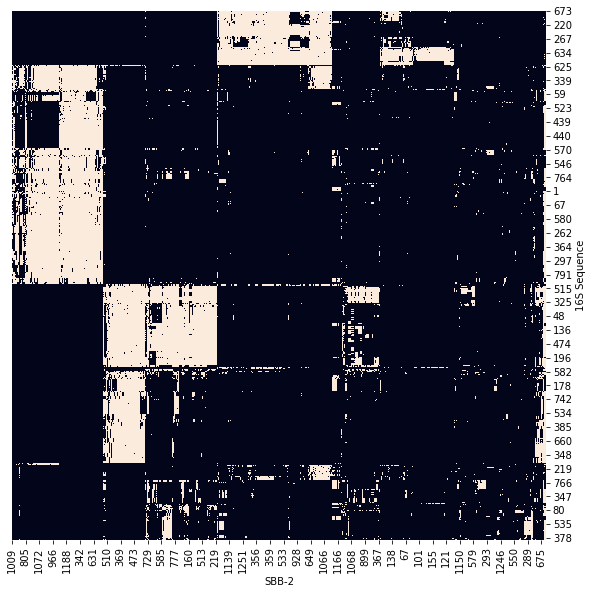

In [6]:
cg = sns.clustermap(asv_biomarker_sig, figsize=(10,10), metric='hamming')
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set_ylabel('16S Sequence')
ax.set_xlabel('SBB-2')
plt.savefig('/home/groups/dpwall/briannac/sequence_based_biomarkers/results/differential_abundances/autism_clusters.png', transparent=True, dpi=300)
plt.savefig('/home/groups/dpwall/briannac/sequence_based_biomarkers/results/differential_abundances/autism_clusters.svg', transparent=True)
plt.show()

50175
[('Ruminococcaceae', 33), ('Eggerthellaceae', 19), ('unclassified', 10), ('Coriobacteriaceae', 8), ('Lachnospiraceae', 8)]
[('unclassified', 29), ('Gordonibacter', 9), ('Hydrogeniiclostridium', 5), ('Oscillibacter', 5), ('Blautia', 5)]


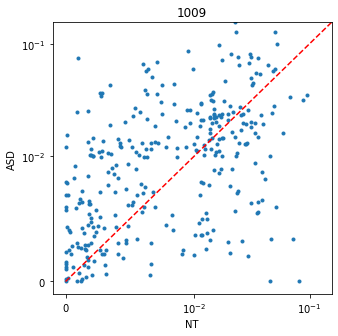

17647
[('unclassified', 87), ('Porphyromonadaceae', 86), ('Erysipelotrichaceae', 24), ('Streptococcaceae', 18), ('Peptoniphilaceae', 14)]
[('unclassified', 119), ('Parabacteroides', 83), ('Streptococcus', 15), ('Campylobacter', 9), ('Anaerococcus', 7)]


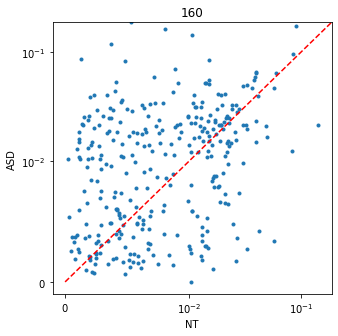

87109
[('Porphyromonadaceae', 88), ('unclassified', 56), ('Sutterellaceae', 49), ('Erysipelotrichaceae', 26), ('Pasteurellaceae', 17)]
[('unclassified', 90), ('Parabacteroides', 83), ('Sutterella', 21), ('Faecalibacillus', 20), ('Parasutterella', 15)]


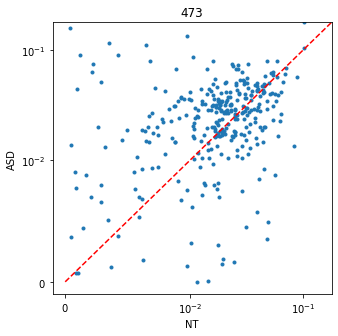

56857
[('Veillonellaceae', 63), ('Selenomonadaceae', 13), ('unclassified', 7)]
[('Veillonella', 27), ('Dialister', 18), ('Megasphaera', 11), ('unclassified', 10), ('Megamonas', 6)]


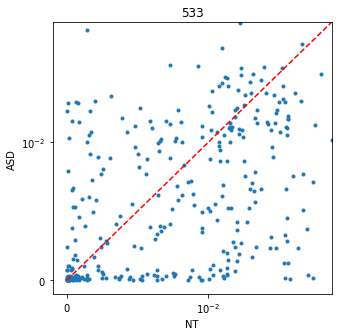

In [288]:
for sbb_id in [1009, 160,473, 533]:
    sbb = sig_sbbs[sbb_id]
    print(sbb)
    NT = person_biomarker[::2,sbb]
    ASD = person_biomarker[1::2,sbb]
    plt.figure(figsize=(5,5))
    plt.plot(NT, ASD, '.')
    plt.xlim(-.001,max(person_biomarker[:,sbb]))
    plt.ylim(-.001,max(person_biomarker[:,sbb]))
    plt.yscale('symlog', linthresh=.01)
    plt.xscale('symlog', linthresh=.01)
    plt.xlabel('NT')
    plt.ylabel('ASD')
    plt.title(sbb_id)
    plt.plot(np.linspace(0,max(person_biomarker[:,sbb]),10), np.linspace(0,max(person_biomarker[:,sbb]),10), 'r--')
    print(Counter(asv_taxa.iloc[np.where(asv_biomarker[:,sbb])[0]].Family).most_common(5))
    print(Counter(asv_taxa.iloc[np.where(asv_biomarker[:,sbb])[0]].Genus).most_common(5))
    plt.savefig('/home/groups/dpwall/briannac/sequence_based_biomarkers/results/differential_abundances/autism_diff_abundance_%i.svg' % sbb_id, transparent=True)
    plt.show()

# Obesity

In [7]:
df = pd.read_table('/home/groups/dpwall/briannac/sequence_based_biomarkers/results/rank_stats/fdr_dataframe.tsv', sep='\t')

In [8]:
dataset = 'obesity'
biomarker = 'sbb2'

stats = np.load('/home/groups/dpwall/briannac/sequence_based_biomarkers/results/rank_stats/rank_stat_%s_%s.npy' % (dataset, biomarker))
person_biomarker = scipy.sparse.load_npz(BIOMARKER_DIR + 'results/generate_biomarkers/sample_vs_biomarker_%s_%s.npz' % (biomarker, dataset)).toarray()
asv_biomarker = scipy.sparse.load_npz(BIOMARKER_DIR + 'results/generate_biomarkers/asv_vs_biomarker_%s_%s.npz' % (biomarker, dataset)).toarray()
asv_taxa = pd.read_table(BIOMARKER_DIR + 'data/%s/asv_vs_taxa_annotation.tsv' % (dataset))
sample_metadata = pd.read_table(BIOMARKER_DIR + 'data/%s/sample_metadata.tsv' % (dataset))
df_biomarker = df[(df.biomarker=='sbb2') & (df.dataset==dataset)]
frac_biomarkers = max(df_biomarker[df_biomarker.y<=.05].x)
n_biomarkers = round((np.shape(asv_biomarker)[1]*frac_biomarkers))

In [9]:
sig_sbbs = np.argsort(abs(stats))[::-1][:n_biomarkers]
asv_biomarker_sig = asv_biomarker[:,sig_sbbs]
sig_asvs = np.where(asv_biomarker_sig.sum(axis=1)>0)[0]
asv_biomarker_sig = asv_biomarker_sig[sig_asvs,:]
person_biomarker_sig = person_biomarker[:,sig_sbbs]
asv_biomarker_sig = asv_biomarker_sig[(asv_biomarker_sig>0).mean(axis=1)>.05]
print(np.shape(asv_biomarker_sig))

(846, 544)


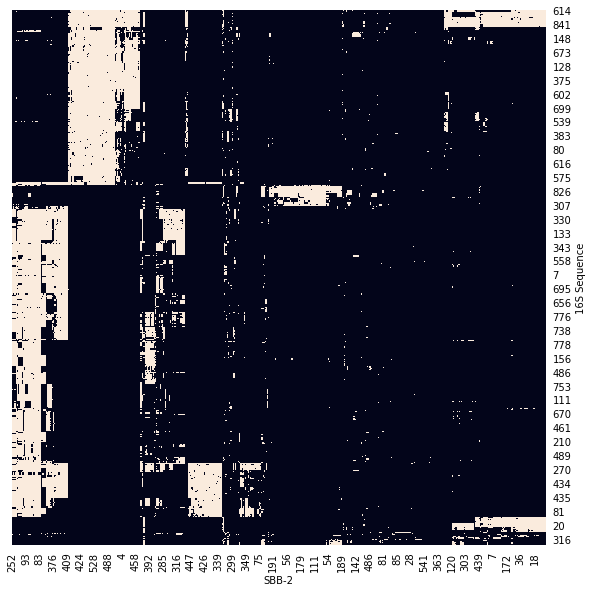

In [10]:
cg = sns.clustermap(asv_biomarker_sig, figsize=(10,10), metric='hamming')
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set_xlabel('SBB-2')
ax.set_ylabel('16S Sequence')
cg.ax_heatmap.tick_params(right=False, bottom=False)
plt.savefig('/home/groups/dpwall/briannac/sequence_based_biomarkers/results/differential_abundances/obesity_clusters.png', transparent=True, dpi=300)
plt.savefig('/home/groups/dpwall/briannac/sequence_based_biomarkers/results/differential_abundances/obesity_clusters.svg', transparent=True)
plt.show()

85279
[('unclassified', 122), ('Veillonellaceae', 118), ('Sutterellaceae', 83), ('Acidaminococcaceae', 31), ('Selenomonadaceae', 31)]
[('unclassified', 210), ('Megasphaera', 54), ('Sutterella', 42), ('Parasutterella', 38), ('Dialister', 28)]


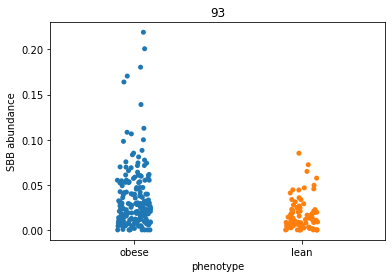

55852
[('Bacteroidaceae', 114), ('Lachnospiraceae', 41), ('Ruminococcaceae', 36), ('unclassified', 31), ('Rikenellaceae', 21)]
[('unclassified', 88), ('Phocaeicola', 67), ('Bacteroides', 45), ('Alistipes', 21), ('Anaerobutyricum', 14)]


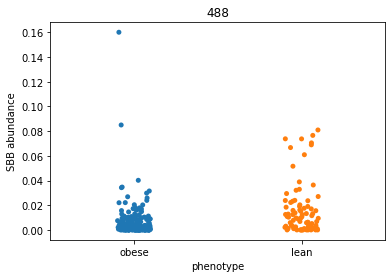

46183
[('Sutterellaceae', 26), ('unclassified', 24), ('Veillonellaceae', 12), ('Selenomonadaceae', 8), ('Enterobacteriaceae', 6)]
[('unclassified', 34), ('Sutterella', 23), ('Megasphaera', 12), ('Megamonas', 8), ('Mailhella', 2)]


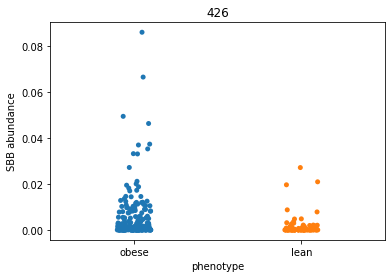

In [293]:
for sbb_id in [93, 488, 426]:
    sbb = sig_sbbs[sbb_id]
    print(sbb)
    print(Counter(asv_taxa.iloc[np.where(asv_biomarker[:,sbb])[0]].Family).most_common(5))
    print(Counter(asv_taxa.iloc[np.where(asv_biomarker[:,sbb])[0]].Genus).most_common(5))
    obese = person_biomarker[:,sbb][np.where(sample_metadata.phenotype==True)]
    lean = person_biomarker[:,sbb][np.where(sample_metadata.phenotype==False)]
    df = pd.concat([pd.DataFrame([obese, ['obese' for o in obese]]).transpose(), pd.DataFrame([lean, ['lean' for o in lean]]).transpose()])
    df.columns = ['SBB abundance', 'phenotype']
    sns.stripplot(data=df, x='phenotype', y='SBB abundance')
    plt.title(sbb_id)
    plt.savefig('/home/groups/dpwall/briannac/sequence_based_biomarkers/results/differential_abundances/obesity_diff_abundance_%i.svg' % sbb_id, transparent=True)
    plt.show()